In [44]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


In [45]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root = 'data',
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

model = NeuralNetwork()
mps_model = NeuralNetwork().to(mps_device)

In [46]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [47]:
loss_fn = nn.CrossEntropyLoss()

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [49]:
def train_loop(device, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        if device == 'GPU':
            X = X.to(mps_device)
            y = y.to(mps_device)
        pred = model(X)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            train_loss.append(loss)
            
    return train_loss
    
def test_loop(device, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for X, y in dataloader:
            if device == 'GPU':
                X = X.to(mps_device)
                y = y.to(mps_device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct +=(pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    
    return correct, test_loss

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
CPU_train_loss = []
CPU_test_acc, CPU_test_loss = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    CPU_train_loss.append(train_loop('CPU',train_dataloader, model, loss_fn, optimizer))
    acc, loss = test_loop('CPU',test_dataloader, model, loss_fn)
    CPU_test_acc.append(acc)
    CPU_test_loss.append(loss)
print("Done")

Epoch 1
----------------------------
loss: 2.289950 [    0/60000]
loss: 2.278657 [ 6400/60000]
loss: 2.262285 [12800/60000]
loss: 2.260108 [19200/60000]
loss: 2.228754 [25600/60000]
loss: 2.204386 [32000/60000]
loss: 2.205395 [38400/60000]
loss: 2.172806 [44800/60000]
loss: 2.170522 [51200/60000]
loss: 2.142329 [57600/60000]
Test Error: 
 Accuracy: 48.2%, Avg loss: 2.130507

Epoch 2
----------------------------
loss: 2.133020 [    0/60000]
loss: 2.121749 [ 6400/60000]
loss: 2.065323 [12800/60000]
loss: 2.082625 [19200/60000]
loss: 2.013892 [25600/60000]
loss: 1.959436 [32000/60000]
loss: 1.972291 [38400/60000]
loss: 1.896264 [44800/60000]
loss: 1.906377 [51200/60000]
loss: 1.822263 [57600/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.826139

Epoch 3
----------------------------
loss: 1.860967 [    0/60000]
loss: 1.824683 [ 6400/60000]
loss: 1.710301 [12800/60000]
loss: 1.747333 [19200/60000]
loss: 1.631518 [25600/60000]
loss: 1.598036 [32000/60000]
loss: 1.600906 [38400/60000]
loss

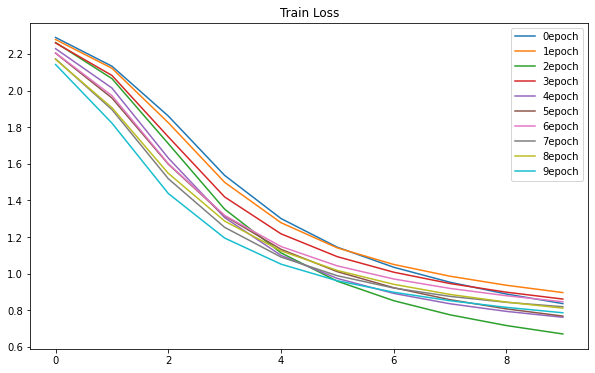

In [62]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
plt.title('Train Loss')
label = []
for i in range(len(CPU_train_loss)):
    label.append(f'{i}epoch')
plt.plot(CPU_train_loss,'-',label=label)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


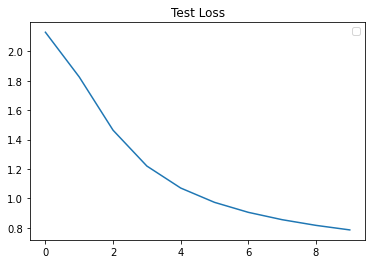

In [59]:
plt.title('Test Loss')
plt.plot(CPU_test_loss,'-')
plt.show()

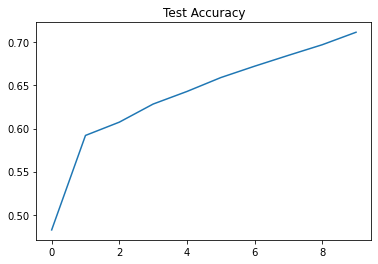

In [63]:
plt.title('Test Accuracy')
plt.plot(CPU_test_acc,'-')
plt.show()

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mps_model.parameters(), lr=learning_rate)

epochs = 10
GPU_train_loss = []
GPU_test_acc, GPU_test_loss = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    GPU_train_loss.append(train_loop('GPU',train_dataloader, mps_model, loss_fn, optimizer))
    acc, loss = test_loop('GPU',test_dataloader, mps_model, loss_fn)
    GPU_test_acc.append(acc)
    GPU_test_loss.append(loss)
print("Done")

Epoch 1
----------------------------
loss: 2.300815 [    0/60000]
loss: 2.293489 [ 6400/60000]
loss: 2.275771 [12800/60000]
loss: 2.269027 [19200/60000]
loss: 2.252857 [25600/60000]
loss: 2.227669 [32000/60000]
loss: 2.225816 [38400/60000]
loss: 2.201706 [44800/60000]
loss: 2.198474 [51200/60000]
loss: 2.167868 [57600/60000]
Test Error: 
 Accuracy: 58.7%, Avg loss: 2.161989

Epoch 2
----------------------------
loss: 2.170928 [    0/60000]
loss: 2.157508 [ 6400/60000]
loss: 2.112168 [12800/60000]
loss: 2.121630 [19200/60000]
loss: 2.062823 [25600/60000]
loss: 2.022481 [32000/60000]
loss: 2.028464 [38400/60000]
loss: 1.964704 [44800/60000]
loss: 1.964363 [51200/60000]
loss: 1.897254 [57600/60000]
Test Error: 
 Accuracy: 59.6%, Avg loss: 1.889266

Epoch 3
----------------------------
loss: 1.923294 [    0/60000]
loss: 1.888434 [ 6400/60000]
loss: 1.781669 [12800/60000]
loss: 1.812356 [19200/60000]
loss: 1.694273 [25600/60000]
loss: 1.662160 [32000/60000]
loss: 1.660928 [38400/60000]
loss

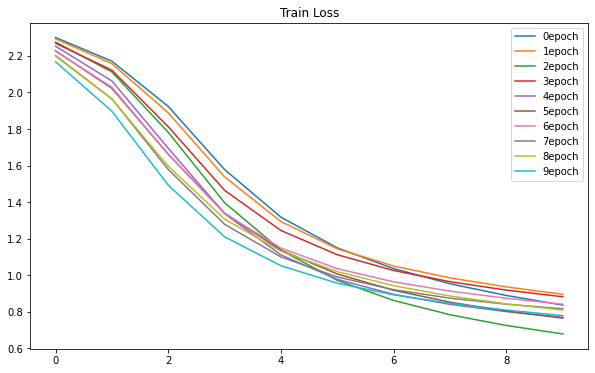

In [64]:
plt.figure(figsize=(10,6))
plt.title('Train Loss')
plt.plot(GPU_train_loss,'-',label=label)
plt.legend()
plt.show()

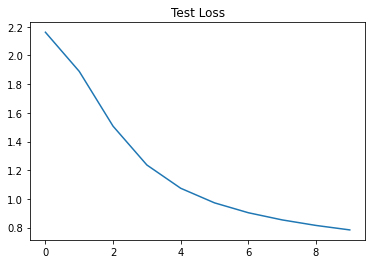

loss : 0.78409


In [74]:
plt.title('Test Loss')
plt.plot(GPU_test_loss,'-')
plt.show()
print(f'loss : {GPU_test_loss[9]:>0.5f}')

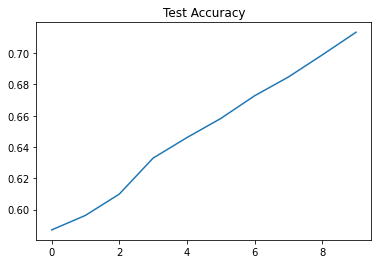

Accuracy : 71.33%


In [72]:
plt.title('Test Accuracy')
plt.plot(GPU_test_acc,'-')
plt.show()
print(f'Accuracy : {GPU_test_acc[9]*100}%')